In [1]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
from qiskit import IBMQ
from qiskit_experiments.framework import ExperimentData, ExperimentDecoder, ExperimentEncoder
from qiskit_research.mzm_generation import KitaevHamiltonianAnalysis

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')

In [3]:
# db_experiment_id = '05e0018a-3329-4197-ac4f-e1a282107029' # 4 qubits bogota (good)
# db_experiment_id = '735128c6-a4a8-4775-b20d-b57ea7019a81' # 5 qubits bogota (good)
db_experiment_id = 'cd4aa849-347f-4d30-a68d-f0f421584228' # 4 qubits cairo (decent)
# db_experiment_id = 'eda7c6d7-fb06-4386-b621-cf9dc0f890d9' # 4 qubits cairo (good) (no mapomatic)
# db_experiment_id = 'bd4879e6-f9ff-4437-abd1-dae894a7acb8' # 3 qubits cairo (good)

# db_experiment_id = '93d7c9e8-02b5-4169-ba3c-0238af2470f0' # 6 qubits cairo (bad)
# db_experiment_id = 'dc229a9a-343a-4cd2-a636-f1cca50b286d' # 5 qubits cairo (bad)

# db_experiment_id = '611f4f2c-67a4-4867-bd95-df60e1b05758' # 3 qubits bogota
# db_experiment_id = 'dddb193c-54f2-4021-af74-7a2df9148023' # 4 qubits cairo (bad)
# db_experiment_id = 'eea9b9f1-2e13-4418-abd5-db2b9300de08' # 6 qubits cairo (garbage)
# db_experiment_id = '599882a2-4529-4273-ab66-2e1f43245f44' # 6 qubits hanoi (garbage)
# db_experiment_id = 'f2a20726-1806-47bd-8d11-cee1aceb1c0d' # 4 qubits bogota
# db_experiment_id = '9f89febc-d9e9-4d60-8bb6-4e93a6b465fa' # 3 qubits lima
# db_experiment_id = '134978a1-ea17-41b5-9e59-fb3f77bf6f30'  # 3 qubits lima (no dd)
# db_experiment_id = 'f6637a82-afe1-44bd-adce-188bf0ddd2a6'  # 4 qubits lima (no dd)

data = ExperimentData.load(db_experiment_id, provider.service('experiment'))

experiment_id = data.metadata['experiment_id']
filename = f'data/{experiment_id}.json'
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, 'w') as f:
    json.dump(data, f, cls=ExperimentEncoder)

print(experiment_id)

2022-03-03T22:02:49.393980_ibm_cairo
None


In [4]:
experiment_id = '2022-03-03T22:02:49.393980_ibm_cairo'
# experiment_id = '2022-03-03T15:22:18.399703_aer_simulator'

filename = f'data/{experiment_id}.json'
with open(filename) as f:
    data = json.load(f, cls=ExperimentDecoder)

/home/kjs/projects/qiskit-experiments/qiskit_experiments/framework/json.py:567: UserWarning: Could not deserialize instance of class <class 'qiskit.providers.ibmq.experiment.ibm_experiment_service.IBMExperimentService'> from settings {}. 
The following exception was raised:
Traceback (most recent call last):
  File "/home/kjs/projects/qiskit-experiments/qiskit_experiments/framework/json.py", line 338, in _deserialize_object
    return cls(**settings)
TypeError: __init__() missing 1 required positional argument: 'provider'

  return _deserialize_object(obj_val)
/home/kjs/projects/qiskit-experiments/qiskit_experiments/framework/json.py:567: UserWarning: Could not deserialize instance of class <class 'qiskit.providers.ibmq.ibmqbackend.IBMQBackend'> from settings {}. 
The following exception was raised:
Traceback (most recent call last):
  File "/home/kjs/projects/qiskit-experiments/qiskit_experiments/framework/json.py", line 338, in _deserialize_object
    return cls(**settings)
TypeError

In [6]:
%%time
experiment_id = data.metadata["experiment_id"]
qubits = data.metadata["qubits"]
n_modes = len(qubits)
tunneling_values = data.metadata["tunneling_values"]
superconducting_values = data.metadata["superconducting_values"]
chemical_potential_values = data.metadata["chemical_potential_values"]
occupied_orbitals_list = [tuple(o) for o in data.metadata["occupied_orbitals_list"]]

# run analysis
analysis = KitaevHamiltonianAnalysis()
data = analysis.run(data, replace_results=True)

# load results
fidelity_witness_avg_raw, fidelity_witness_stddev_raw = data.analysis_results('fidelity_witness_avg_raw').value
fidelity_witness_avg_mem, fidelity_witness_stddev_mem = data.analysis_results('fidelity_witness_avg_mem').value
fidelity_witness_avg_ps, fidelity_witness_stddev_ps = data.analysis_results('fidelity_witness_avg_ps').value
fidelity_witness_avg_pur, fidelity_witness_stddev_pur = data.analysis_results('fidelity_witness_avg_pur').value

energy_exact = data.analysis_results('energy_exact').value
energy_raw = data.analysis_results('energy_raw').value
energy_mem = data.analysis_results('energy_mem').value
energy_ps = data.analysis_results('energy_ps').value
energy_pur = data.analysis_results('energy_pur').value

bdg_energy_exact = data.analysis_results('bdg_energy_exact').value
bdg_energy_raw, bdg_energy_stddev_raw = data.analysis_results('bdg_energy_raw').value
bdg_energy_mem, bdg_energy_stddev_mem = data.analysis_results('bdg_energy_mem').value
bdg_energy_ps, bdg_energy_stddev_ps = data.analysis_results('bdg_energy_ps').value
bdg_energy_pur, bdg_energy_stddev_pur = data.analysis_results('bdg_energy_pur').value

edge_correlation_exact = data.analysis_results('edge_correlation_exact').value
edge_correlation_raw = data.analysis_results('edge_correlation_raw').value
edge_correlation_mem = data.analysis_results('edge_correlation_mem').value
edge_correlation_ps = data.analysis_results('edge_correlation_ps').value
edge_correlation_pur = data.analysis_results('edge_correlation_pur').value

site_correlation_exact = data.analysis_results('site_correlation_exact').value
site_correlation_raw = data.analysis_results('site_correlation_raw').value
site_correlation_mem = data.analysis_results('site_correlation_mem').value
site_correlation_ps = data.analysis_results('site_correlation_ps').value
site_correlation_pur = data.analysis_results('site_correlation_pur').value

parity_exact = data.analysis_results('parity_exact').value
parity_raw = data.analysis_results('parity_raw').value
parity_mem = data.analysis_results('parity_mem').value
parity_ps = data.analysis_results('parity_ps').value

number_exact = data.analysis_results('number_exact').value
number_raw = data.analysis_results('number_raw').value
number_mem = data.analysis_results('number_mem').value
number_ps = data.analysis_results('number_ps').value
number_pur = data.analysis_results('number_pur').value

energy_error_raw, energy_error_stddev_raw = data.analysis_results('energy_error_raw').value
energy_error_mem, energy_error_stddev_mem = data.analysis_results('energy_error_mem').value
energy_error_ps, energy_error_stddev_ps = data.analysis_results('energy_error_ps').value
energy_error_pur, energy_error_stddev_pur = data.analysis_results('energy_error_pur').value

bdg_energy_error_raw, bdg_energy_error_stddev_raw = data.analysis_results('bdg_energy_error_raw').value
bdg_energy_error_mem, bdg_energy_error_stddev_mem = data.analysis_results('bdg_energy_error_mem').value
bdg_energy_error_ps, bdg_energy_error_stddev_ps = data.analysis_results('bdg_energy_error_ps').value
bdg_energy_error_pur, bdg_energy_error_stddev_pur = data.analysis_results('bdg_energy_error_pur').value

# fidelity_witness_avg_pur_x2pm, fidelity_witness_stddev_pur_x2pm = data.analysis_results('fidelity_witness_avg_pur_X2pm').value
# energy_pur_x2pm = data.analysis_results('energy_pur_X2pm').value
# bdg_energy_x2pm, bdg_energy_stddev_x2pm = data.analysis_results('bdg_energy_X2pm').value
# energy_error_pur_x2pm, energy_error_stddev_pur_x2pm = data.analysis_results('energy_error_pur_X2pm').value

# fidelity_witness_avg_pur_xy4pm, fidelity_witness_stddev_pur_xy4pm = data.analysis_results('fidelity_witness_avg_pur_XY4pm').value
# energy_pur_xy4pm = data.analysis_results('energy_pur_XY4pm').value
# bdg_energy_pur_xy4pm, bdg_energy_stddev_pur_xy4pm = data.analysis_results('bdg_energy_pur_XY4pm').value
# energy_error_pur_xy4pm, energy_error_stddev_pur_xy4pm = data.analysis_results('energy_error_pur_XY4pm').value

# fidelity_witness_avg_pur_xy8pm, fidelity_witness_stddev_pur_xy8pm = data.analysis_results('fidelity_witness_avg_pur_XY8pm').value
# energy_pur_xy8pm = data.analysis_results('energy_pur_XY8pm').value
# bdg_energy_xy8pm, bdg_energy_stddev_xy8pm = data.analysis_results('bdg_energy_pur_XY8pm').value
# energy_error_pur_xy8pm, energy_error_stddev_pur_xy8pm = data.analysis_results('energy_error_pur_XY8pm').value

# create plot directory
PLOT_DIR = f'plots/n{n_modes}/{experiment_id}'
os.makedirs(PLOT_DIR, exist_ok=True)

# set plot options
dpi = 150
filetype = 'png'

Traceback (most recent call last):
Analysis callback failed [Analysis ID: de5ee7d84e9f43d1a215a017ea54f13d]:
  File "/home/kjs/projects/qiskit-experiments/qiskit_experiments/database_service/db_experiment_data.py", line 502, in _run_analysis_callback
    callback(self, **kwargs)
Analysis callback failed [Analysis ID: de5ee7d84e9f43d1a215a017ea54f13d]:
  File "/home/kjs/projects/qiskit-experiments/qiskit_experiments/framework/base_analysis.py", line 157, in run_analysis
    results, figures = analysis._run_analysis(expdata)
Analysis callback failed [Analysis ID: de5ee7d84e9f43d1a215a017ea54f13d]:
  File "/home/kjs/projects/qiskit-research/qiskit_research/mzm_generation/analysis.py", line 115, in _run_analysis
    backend.name(),
Analysis callback failed [Analysis ID: de5ee7d84e9f43d1a215a017ea54f13d]:
AttributeError: 'dict' object has no attribute 'name'



AttributeError: 'dict' object has no attribute 'analysis_results'

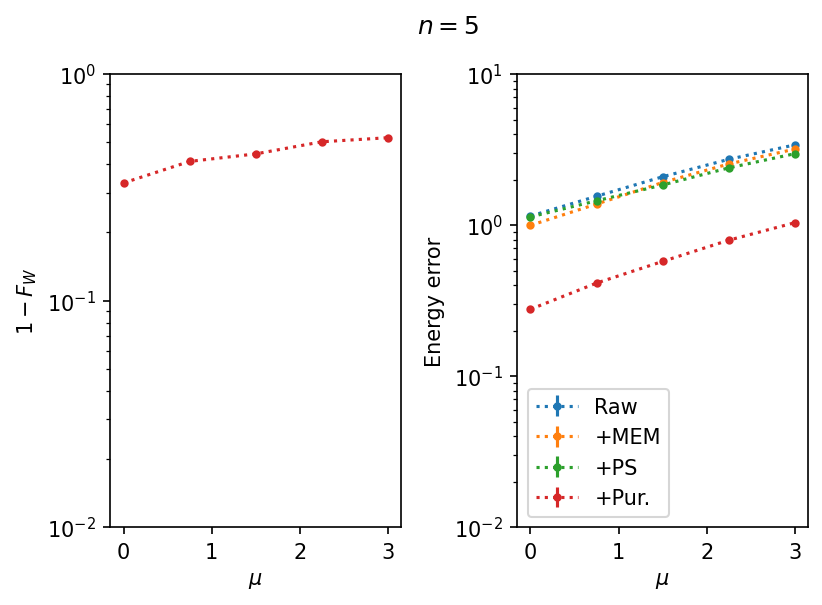

In [41]:
# plot fidelity witness and average energy error
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=dpi)
fig.subplots_adjust(wspace=0.4)

ax1.errorbar(
    chemical_potential_values,
    1 - fidelity_witness_avg_raw,
    yerr=2 * fidelity_witness_stddev_raw,
    fmt=".:",
    label="Raw",
)
ax1.errorbar(
    chemical_potential_values,
    1 - fidelity_witness_avg_mem,
    yerr=2 * fidelity_witness_stddev_mem,
    fmt=".:",
    label="+MEM",
)
ax1.errorbar(
    chemical_potential_values,
    1 - fidelity_witness_avg_ps,
    yerr=2 * fidelity_witness_stddev_ps,
    fmt=".:",
    label="+PS",
)
ax1.errorbar(
    chemical_potential_values,
    1 - fidelity_witness_avg_pur,
    yerr=2 * fidelity_witness_stddev_pur,
    fmt=".:",
    label="+Pur.",
)
ax1.set_xlabel(r"$\mu$")
ax1.set_ylabel(r"$1 - F_W$")
ax1.set_yscale('log')
ax1.set_ylim(1e-2, 1)

ax2.errorbar(
    chemical_potential_values,
    energy_error_raw,
    yerr=2 * energy_error_stddev_raw,
    fmt=".:",
    label="Raw",
)
ax2.errorbar(
    chemical_potential_values,
    energy_error_mem,
    yerr=2 * energy_error_stddev_mem,
    fmt=".:",
    label="+MEM",
)
ax2.errorbar(
    chemical_potential_values,
    energy_error_ps,
    yerr=2 * energy_error_stddev_ps,
    fmt=".:",
    label="+PS",
)
ax2.errorbar(
    chemical_potential_values,
    energy_error_pur,
    yerr=2 * energy_error_stddev_pur,
    fmt=".:",
    label="+Pur.",
)
ax2.set_xlabel(r"$\mu$")
ax2.set_ylabel(r"Energy error")
ax2.set_yscale('log')
ax2.set_ylim(1e-2, 10)
ax2.legend()
fig.suptitle(fr"$n = {n_modes}$")

data.add_figures(fig, 'fidelity_witness', overwrite=True)
plt.savefig(f'{PLOT_DIR}/fidelity_witness_n{n_modes}.{filetype}')
plt.show()

NameError: name 'fidelity_witness_avg_pur_xy4pm' is not defined

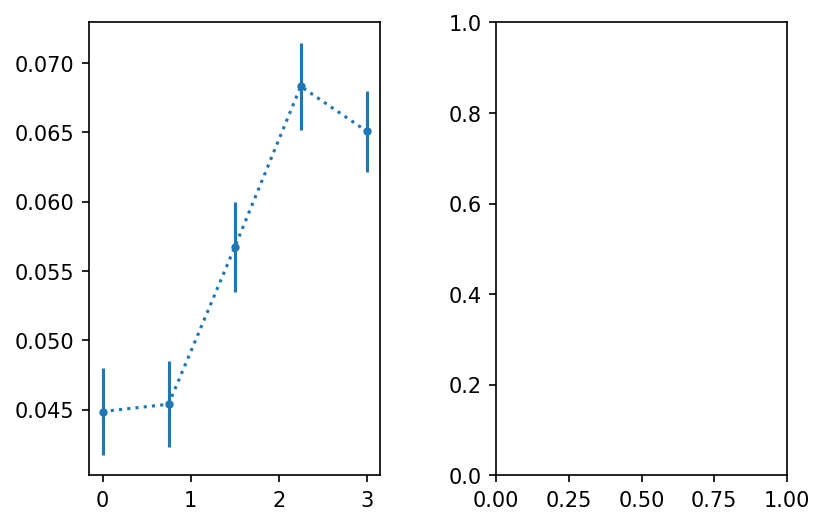

In [35]:
# plot fidelity witness and average energy error
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=dpi)
fig.subplots_adjust(wspace=0.4)

ax1.errorbar(
    chemical_potential_values,
    1 - fidelity_witness_avg_pur,
    yerr=2 * fidelity_witness_stddev_pur,
    fmt=".:",
    label="No DD",
)
ax1.errorbar(
    chemical_potential_values,
    1 - fidelity_witness_avg_pur_xy4pm,
    yerr=2 * fidelity_witness_stddev_pur_xy4pm,
    fmt=".:",
    label="DD-XY4pm",
)
ax1.set_xlabel(r"$\mu$")
ax1.set_ylabel(r"$1 - F_W$")
ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1)

ax2.errorbar(
    chemical_potential_values,
    energy_error_pur,
    yerr=2 * energy_error_stddev_pur,
    fmt=".:",
    label="No DD",
)
ax2.errorbar(
    chemical_potential_values,
    energy_error_pur_xy4pm,
    yerr=2 * energy_error_stddev_pur_xy4pm,
    fmt=".:",
    label="DD-XY4pm",
)
ax2.set_xlabel(r"$\mu$")
ax2.set_ylabel(r"Energy error")
ax2.set_yscale('log')
ax2.set_ylim(1e-3, 1)
ax2.legend()
fig.suptitle(fr"$n = {n_modes}$")

data.add_figures(fig, 'fidelity_witness_dd', overwrite=True)
plt.savefig(f'{PLOT_DIR}/fidelity_witness_dd_n{n_modes}.{filetype}')
plt.show()

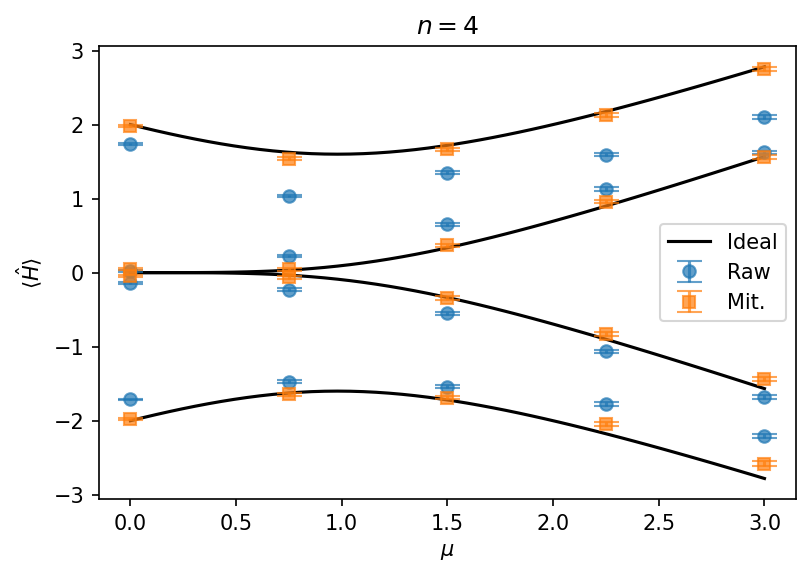

In [36]:
# plot BdG energies
fig, ax = plt.subplots(dpi=dpi)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
capsize = 6

for i, energies in enumerate(bdg_energy_exact[0]):
    ax.plot(
        bdg_energy_exact[1],
        energies,
        color='black',
        label=None if i else 'Ideal'
    )
threshold = len(bdg_energy_raw) // 2

for i in range(threshold):
    error1 = ax.errorbar(
        chemical_potential_values,
        bdg_energy_raw[i],
        yerr=2 * bdg_energy_stddev_raw[i],
        fmt='o',
        capsize=capsize,
        color=colors[0],
        alpha=0.7,
        label=None if i else 'Raw'
    )
    ax.errorbar(
        chemical_potential_values,
        bdg_energy_raw[threshold + i],
        yerr=2 * bdg_energy_stddev_raw[threshold + i],
        fmt='o',
        capsize=capsize,
        color=colors[0],
        alpha=0.7,
    )
    error2 = ax.errorbar(
        chemical_potential_values,
        bdg_energy_pur[i],
        yerr=2 * bdg_energy_stddev_pur[i],
        fmt='s',
        capsize=capsize,
        color=colors[1],
        alpha=0.7,
        label=None if i else 'Mit.'
    )
    ax.errorbar(
        chemical_potential_values,
        bdg_energy_pur[threshold + i],
        yerr=2 * bdg_energy_stddev_pur[1],
        fmt='s',
        capsize=capsize,
        color=colors[1],
        alpha=0.7,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle \hat{H} \rangle$")
ax.legend(loc='right')
ax.set_title(fr"$n = {n_modes}$")

data.add_figures(fig, 'bdg_energy', overwrite=True)
plt.savefig(f'{PLOT_DIR}/bdg_energy_n{n_modes}.{filetype}')

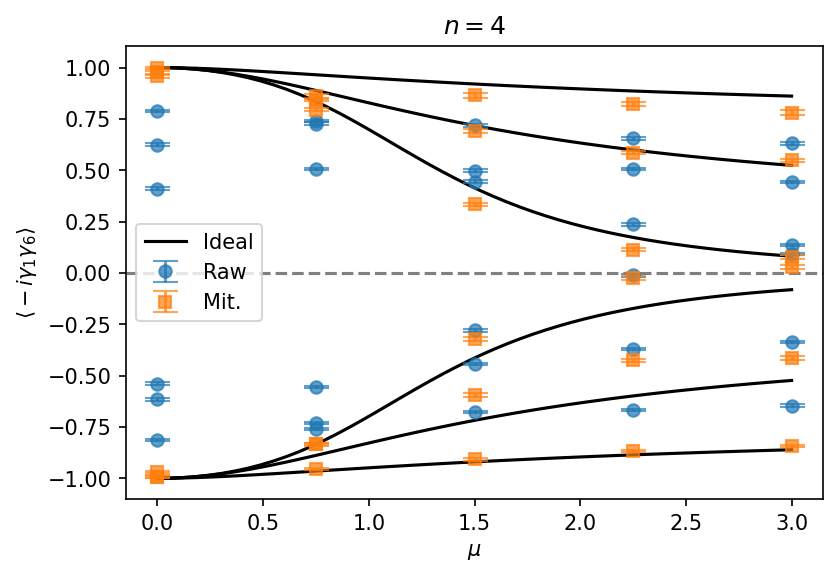

In [37]:
# plot edge correlation
fig, ax = plt.subplots(dpi=dpi)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
capsize = 6

for occupied_orbitals, (edge_correlations, xvals) in edge_correlation_exact.items():
    color = "black"
    ax.plot(xvals,
            edge_correlations,
            color=color,
            label="Ideal" if not occupied_orbitals else None,)

for occupied_orbitals, (edge_correlations, stddevs) in edge_correlation_raw.items():
    ax.errorbar(
        chemical_potential_values,
        edge_correlations,
        yerr=2 * np.array(stddevs),
        fmt='o',
        capsize=capsize,
        color=colors[0],
        alpha=0.7,
        label="Raw" if not occupied_orbitals else None,
    )
for occupied_orbitals, (edge_correlations, stddevs) in edge_correlation_pur.items():
    ax.errorbar(
        chemical_potential_values,
        edge_correlations,
        yerr=2 * np.array(stddevs),
        fmt='s',
        capsize=capsize,
        color=colors[1],
        alpha=0.7,
        label="Mit." if not occupied_orbitals else None,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle -i \gamma_1 \gamma_6 \rangle$")
ax.axhline([0], color='gray', linestyle='--')
ax.legend(loc='center left')
ax.set_title(fr"$n = {n_modes}$")

data.add_figures(fig, 'edge_correlation', overwrite=True)
plt.savefig(f'{PLOT_DIR}/edge_correlation_n{n_modes}.{filetype}')
plt.show()

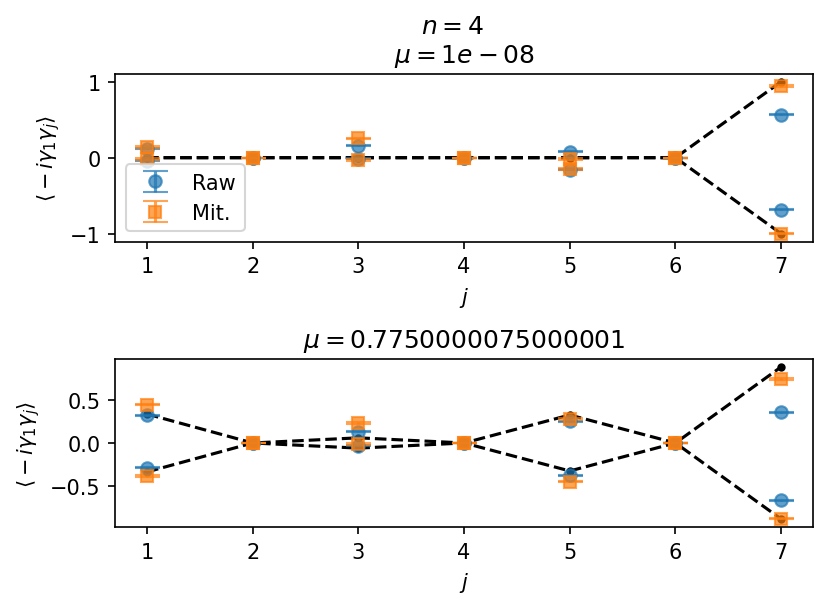

In [30]:
# plot site correlation
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
capsize = 6

xvals = range(1, 2 * n_modes)
occupied_orbitals_to_plot = occupied_orbitals_list[2:4]
fig, axes = plt.subplots(2, 1, dpi=dpi)
fig.subplots_adjust(hspace=0.7)
for index, (ax, chemical_potential) in enumerate(zip(axes, chemical_potential_values[:2])):
    for occupied_orbitals in occupied_orbitals_to_plot:
        site_correlations = site_correlation_exact[chemical_potential, occupied_orbitals]
        ax.plot(
            xvals,
            site_correlations,
            '.--',
            color="black",
            label="Ideal" if not occupied_orbitals else None
        )
    for i, occupied_orbitals in enumerate(occupied_orbitals_to_plot):
        (vals, stddevs) = site_correlation_raw[chemical_potential, occupied_orbitals]
        ax.errorbar(
            xvals,
            vals,
            yerr=2 * np.array(stddevs),
            fmt='o',
            capsize=capsize,
            color=colors[0],
            alpha=0.7,
            label=None if i else 'Raw'
        )
    for i, occupied_orbitals in enumerate(occupied_orbitals_to_plot):
        (vals, stddevs) = site_correlation_pur[chemical_potential, occupied_orbitals]
        ax.errorbar(
            xvals,
            vals,
            yerr=2 * np.array(stddevs),
            fmt='s',
            capsize=capsize,
            color=colors[1],
            alpha=0.7,
            label=None if i else 'Mit.'
        )
    ax.set_xlabel(r"$j$")
    ax.set_ylabel(r"$\langle -i \gamma_1 \gamma_j \rangle$")
    ax.set_xticks(xvals)
    if index == 0:
        ax.legend()
    ax.set_title(fr"$\mu={chemical_potential}$")

fig.suptitle(fr"$n = {n_modes}$")
data.add_figures(fig, f'site_correlation', overwrite=True)
plt.savefig(f'{PLOT_DIR}/site_correlation_n{n_modes}.{filetype}')
plt.show()

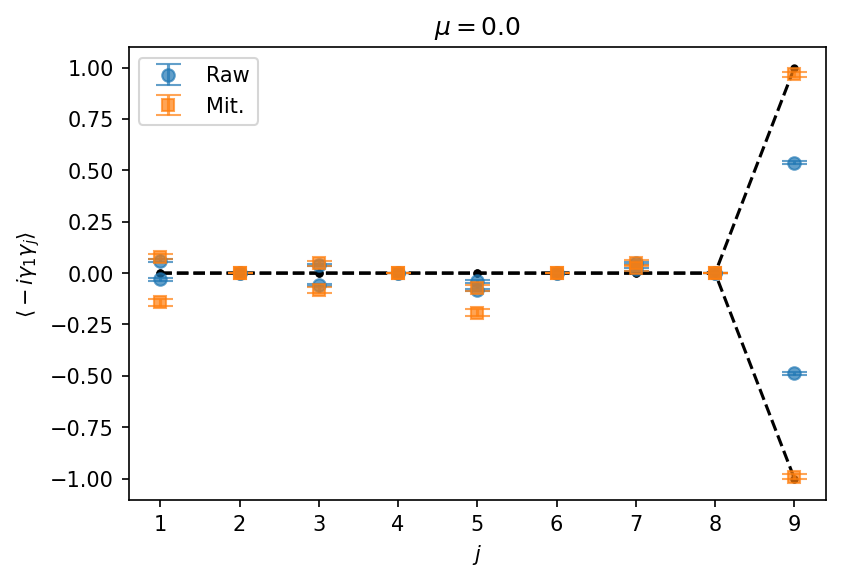

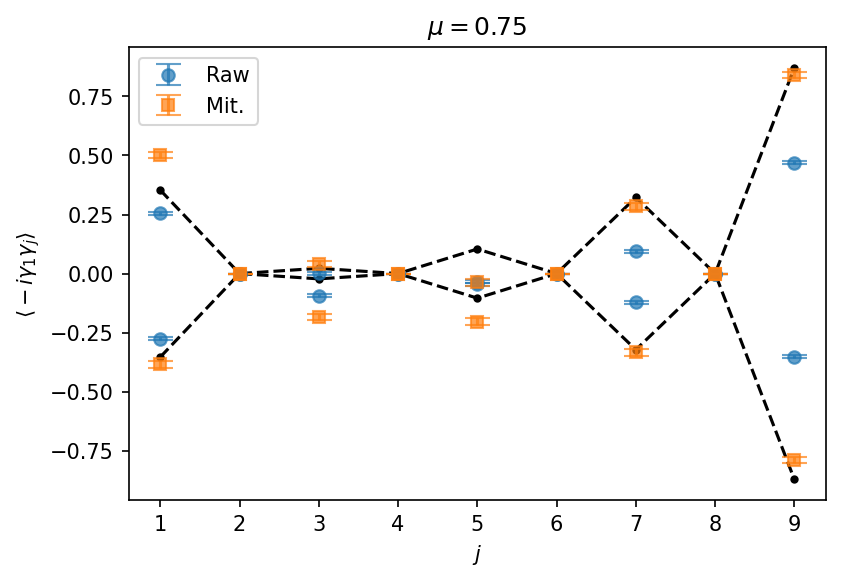

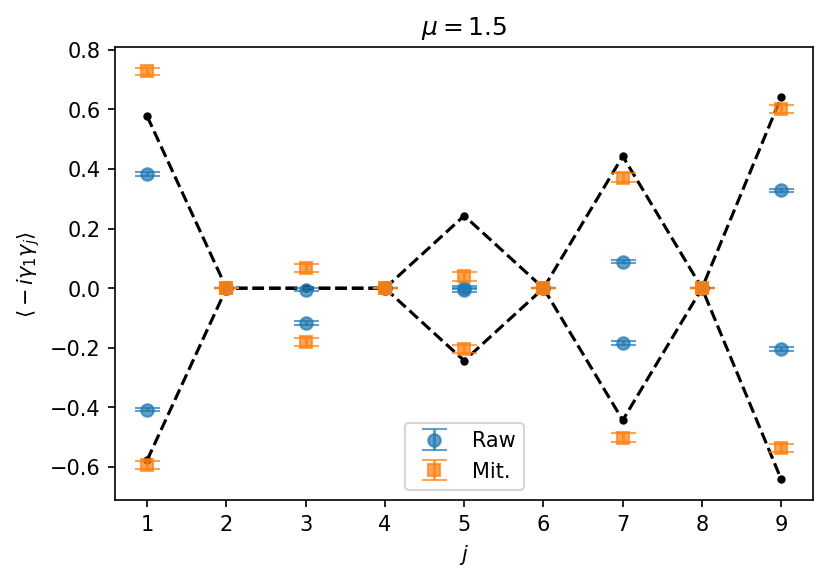

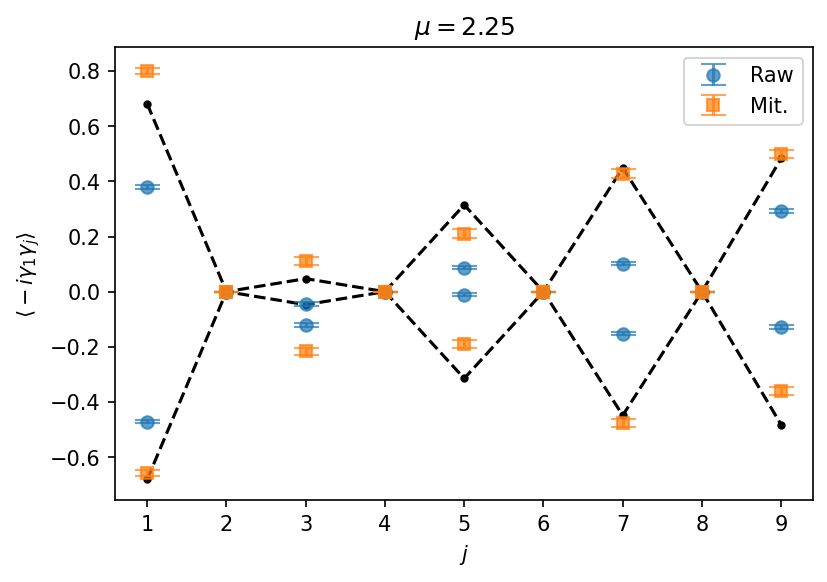

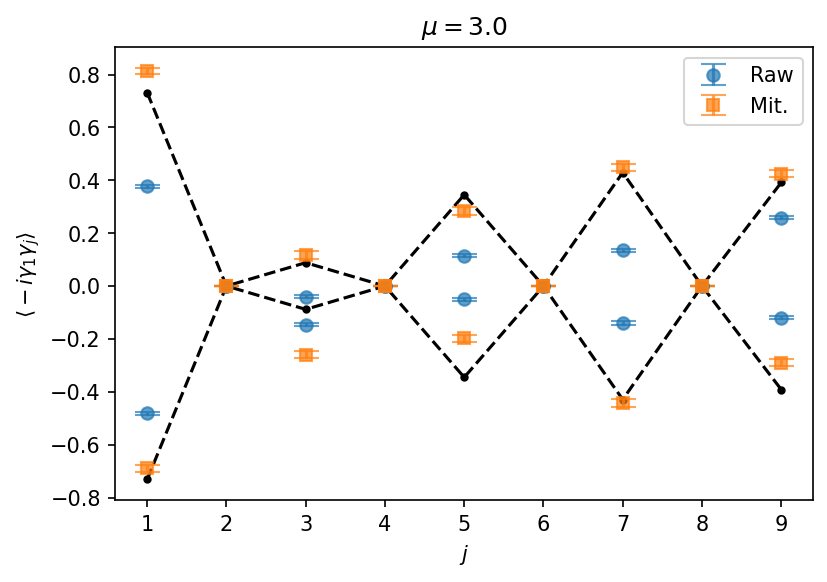

In [10]:
# plot site correlation
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
capsize = 6

xvals = range(1, 2 * n_modes)
occupied_orbitals_to_plot = occupied_orbitals_list[2:4]
for chemical_potential in chemical_potential_values:
    fig, ax = plt.subplots(dpi=dpi)
    for occupied_orbitals in occupied_orbitals_to_plot:
        site_correlations = site_correlation_exact[chemical_potential, occupied_orbitals]
        ax.plot(
            xvals,
            site_correlations,
            '.--',
            color="black",
            label="Ideal" if not occupied_orbitals else None
        )
    for i, occupied_orbitals in enumerate(occupied_orbitals_to_plot):
        (vals, stddevs) = site_correlation_raw[chemical_potential, occupied_orbitals]
        ax.errorbar(
            xvals,
            vals,
            yerr=2 * np.array(stddevs),
            fmt='o',
            capsize=capsize,
            color=colors[0],
            alpha=0.7,
            label=None if i else 'Raw'
        )
    for i, occupied_orbitals in enumerate(occupied_orbitals_to_plot):
        (vals, stddevs) = site_correlation_pur[chemical_potential, occupied_orbitals]
        ax.errorbar(
            xvals,
            vals,
            yerr=2 * np.array(stddevs),
            fmt='s',
            capsize=capsize,
            color=colors[1],
            alpha=0.7,
            label=None if i else 'Mit.'
        )
    ax.set_xlabel(r"$j$")
    ax.set_ylabel(r"$\langle -i \gamma_1 \gamma_j \rangle$")
    ax.set_xticks(xvals)
    ax.legend()
    ax.set_title(fr"$\mu={chemical_potential}$")

    data.add_figures(fig, f'site_correlation_mu{chemical_potential}_n{n_modes}', overwrite=True)
    plt.savefig(f'{PLOT_DIR}/site_correlation_mu{chemical_potential}_n{n_modes}.{filetype}')
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


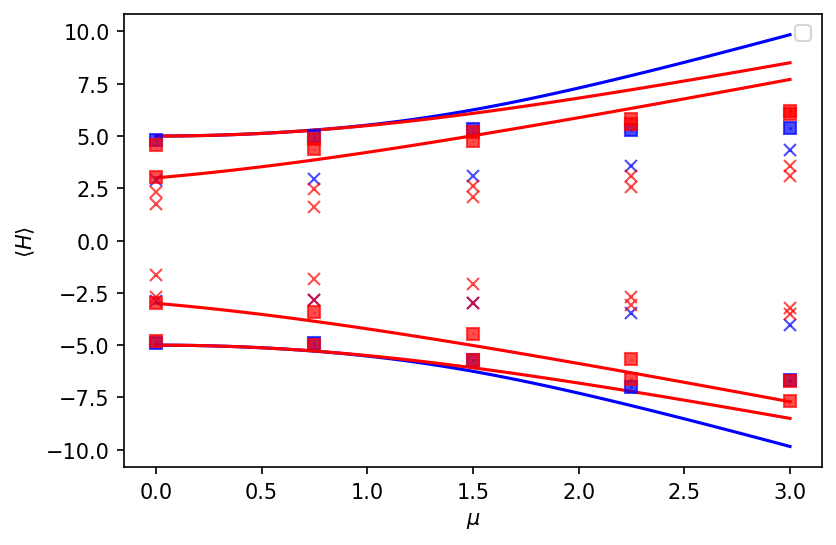

In [23]:
# plot energy
fig, ax = plt.subplots(dpi=dpi)

for occupied_orbitals, (energies, xvals) in energy_exact.items():
    label = "Ideal" if not i else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(
        xvals, energies, label=label, color=color
    )
for occupied_orbitals, (energies, stddevs) in energy_raw.items():
    label = "Raw" if not i else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="x",
        label=label,
        color=color,
        alpha=0.7,
    )
for occupied_orbitals, (energies, stddevs) in energy_pur.items():
    label = "Mit." if not i else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="s",
        label=label,
        color=color,
        alpha=0.7,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle H \rangle$")
ax.legend()

data.add_figures(fig, 'energy', overwrite=True)
plt.savefig(f'{PLOT_DIR}/energy.{filetype}')
plt.show()

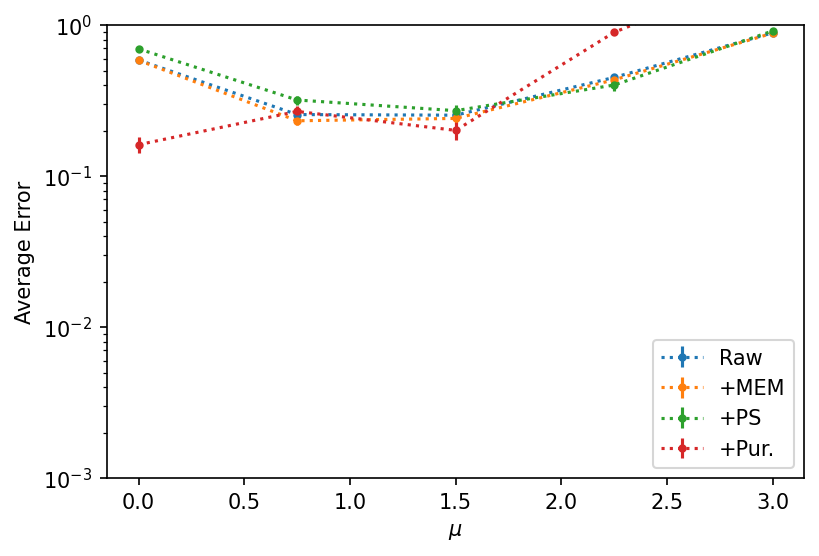

In [24]:
# plot BdG energies average error
fig, ax = plt.subplots(dpi=dpi)
ax.errorbar(
    chemical_potential_values,
    bdg_energy_error_raw,
    yerr=2 * bdg_energy_error_stddev_raw,
    fmt=".:",
    label="Raw",
)
ax.errorbar(
    chemical_potential_values,
    bdg_energy_error_mem,
    yerr=2 * bdg_energy_error_stddev_mem,
    fmt=".:",
    label="+MEM",
)
ax.errorbar(
    chemical_potential_values,
    bdg_energy_error_ps,
    yerr=2 * bdg_energy_error_stddev_ps,
    fmt=".:",
    label="+PS",
)
ax.errorbar(
    chemical_potential_values,
    bdg_energy_error_pur,
    yerr=2 * bdg_energy_error_stddev_pur,
    fmt=".:",
    label="+Pur.",
)
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"Average Error")
ax.set_yscale('log')
ax.set_ylim(1e-3, 1)
ax.legend(loc='lower right')

data.add_figures(fig, 'bdg_energy_error', overwrite=True)
plt.savefig(f'{PLOT_DIR}/bdg_energy_error.{filetype}')
plt.show()

TypeError: list indices must be integers or slices, not tuple

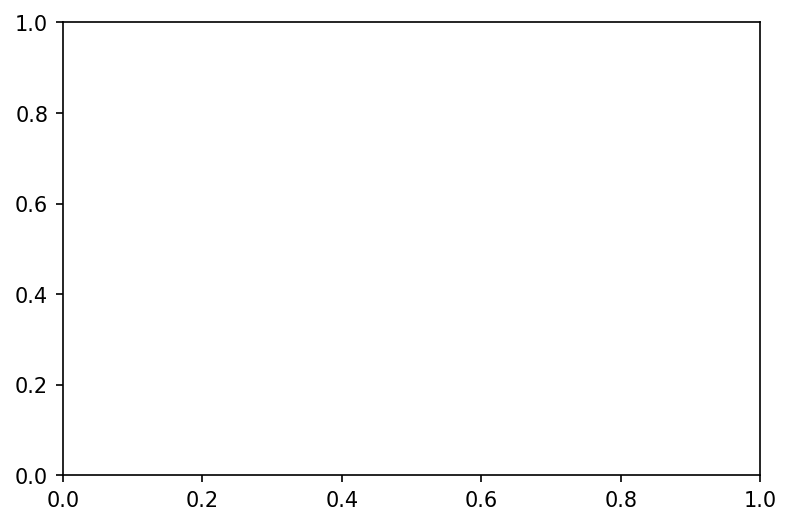

In [23]:
# plot number
fig, ax = plt.subplots(dpi=dpi)
# colors = {
#     (): "darkblue",
#     (0,): "blue",
#     (1,): "cyan",
#     (2,): "greenyellow",
#     (0, 1): "green",
#     (0, 2): "orange",
#     (1, 2): "red",
#     (0, 1, 2): "violet",
#     (0, 1, 2, 3): "black",
# }
for occupied_orbitals, (numbers, xvals) in number_exact.items():
    label = "Ideal" if not occupied_orbitals else None
    ax.plot(
        xvals,
        numbers,
        label=label,
        color=colors[occupied_orbitals],
    )
for occupied_orbitals, (numbers, stddevs) in number_raw.items():
    label = "Raw" if not occupied_orbitals else None
    ax.errorbar(
        chemical_potential_values,
        numbers,
        yerr=2 * np.array(stddevs),
        fmt="x:",
        label=label,
        color=colors[occupied_orbitals],
        alpha=0.7,
    )
for occupied_orbitals, (numbers, stddevs) in number_pur.items():
    label = "Mit." if not occupied_orbitals else None
    ax.errorbar(
        chemical_potential_values,
        numbers,
        yerr=2 * np.array(stddevs),
        fmt="s:",
        label=label,
        color=colors[occupied_orbitals],
        alpha=0.7,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle N \rangle$")
ax.legend()

data.add_figures(fig, 'number', overwrite=True)
plt.savefig(f'plots/{experiment_id}/number.{filetype}')
plt.show()

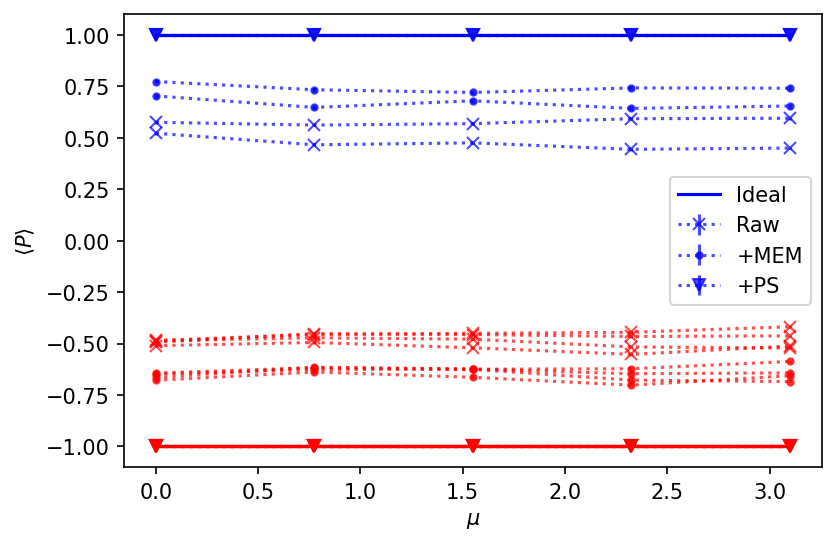

In [24]:
# plot parity
fig, ax = plt.subplots(dpi=dpi)
for occupied_orbitals, (parities, xvals) in parity_exact.items():
    label = "Ideal" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(xvals, parities, label=label, color=color)
for occupied_orbitals, (parities, stddevs) in parity_raw.items():
    label = "Raw" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        parities,
        yerr=2 * np.array(stddevs),
        fmt="x:",
        label=label,
        color=color,
        alpha=0.7,
    )
for occupied_orbitals, (parities, stddevs) in parity_mem.items():
    label = "+MEM" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        parities,
        yerr=2 * np.array(stddevs),
        fmt=".:",
        label=label,
        color=color,
        alpha=0.7,
    )
for occupied_orbitals, (parities, stddevs) in parity_ps.items():
    label = "+PS" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        parities,
        yerr=2 * np.array(stddevs),
        fmt="v:",
        label=label,
        color=color,
        alpha=0.7,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle P \rangle$")
ax.set_ylim(-1.1, 1.1)
ax.legend()

data.add_figures(fig, 'parity', overwrite=True)
plt.savefig(f'plots/{experiment_id}/parity.{filetype}')
plt.show()